___

# [ Geoinformatika ]

## Hluboké učení


**Katedra aplikované geoinformatiky a kartografie**, Přírodovědecká fakulta, Univerzita Karlova
Albertov 6, 128 43 Praha 2

*Lukáš Brodský lukas.brodsky@natur.cuni.cz*


## Hluboké učení - konvoluční neuronové sítě


Tento Jupyter notbooku demonstruje hluboké učení s využitím algoritmu umělé neuronové sítě pomocí knihovny PyTorch (*https://pytorch.org/*). 

Tato neuronová síť (viz **schéma architektury sítě** níže) se skládá ze více vrstev (3+) které se v případě CNN skládá ze dvou hlavních fází: 

1/ **procesu učení se příznaků** pomocí těchto komponent: konvoluční vrstva, aktivační fukce (např. ReLU) a převzorkování (maxpool vrstva),

2/ a **klasifikačního procesu** pomocí standardních neuronů (lineární kombinace). 

Ve výstupní vrsvě je zpravidla implementována aktivační funkce **softmax**. 

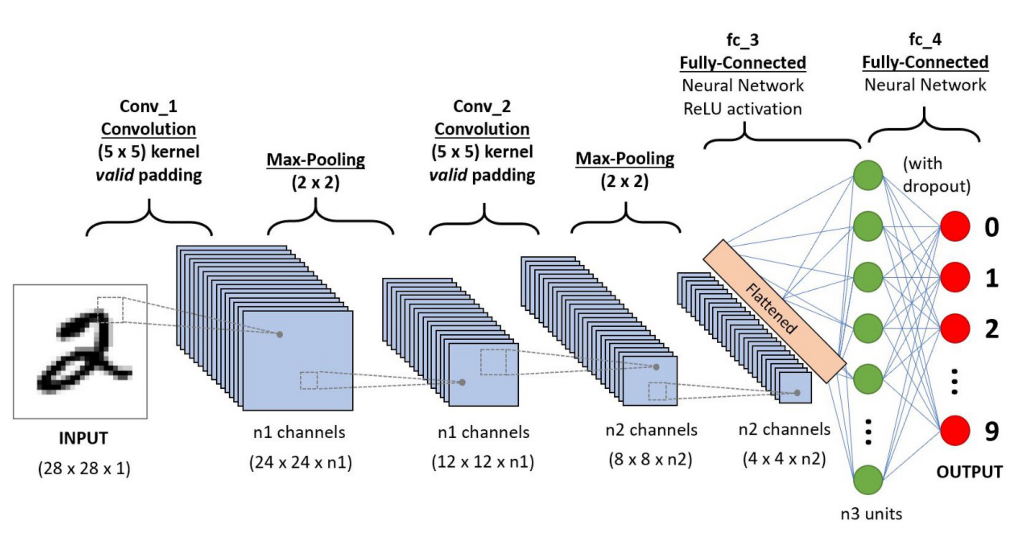

In [246]:
# vizualizace konvoluční neuronové sítě 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
%matplotlib inline 

dt = mpimg.imread('cnn.jpeg')
plt.figure(figsize=(13, 8), dpi=100)
plt.axis('off')
plt.imshow(dt)

**Ztrátové skóre**: 

Ztrátová funkce určuje míru rozdílu predikce a referenčních hodnot, neboli ground truth (GT). Mezi nejčastější z nich patří: L1 ztráta, L2 ztráta, nebo **Křížová entropie** (Cross Entropy Loss). 

Křížová entropie je pravděpodobnost příslušnosti daného pixelu do dané třídy. 

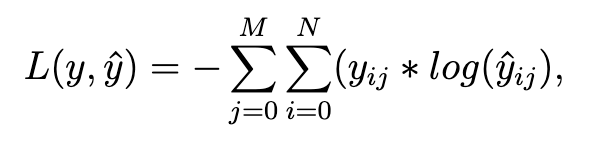

kde y je ground truth hodnota, y_hat je predikovaná hodnota a N je počet testovaných dat a M představuje počet tříd. Výstupem je vektor o délce, která odpovídá počtu predikovaných tříd a jednotlivé pravděpodobnosti, které odpovídájí s jakou přílušností daný pixel odpovídá dané třídě. 


**Optimalizační algoritmus**: 

Optimalizační algoritmy jsou metody, které se snaží minimalizovat resp. maximalizovat chybovou funkci pomocí změn vnitřních parametrů trénovaného modelu. Díky změnám vah nebo rychlosti učení je dosaženo přesnějších výsledků. 

Standrdní metodou optimalizace stochastický gradientní sestup - **SGD - Stochastic Gradient Descent**. **ADAM algoritmus neboli Adpative Moment Estimation** algoritmus je varianta SGD stochastické optimalizační metody. Tento algoritmus vytváří schéma optimalizace ve kterém bere do úvahy jak předchozí čtvercové gradienty, tak i klouzavé průměry gradientů. ADAM algoritmus postupně aktualizuje exponenciální klouzavé průměry gradientů, což umožňuje výpočet **individuální rychlosti učení pro různé parametry**.


### Úloha: klasifikace MNIST 

Vytvořte klasifikační model pomocí konvoluční neuronové sítě pro predikci ručně psaných číslic z datasetu MNIST. Ověřte přesnost modelu pro různé komplexity sítě (různé počty filterů, případně vrstev). 

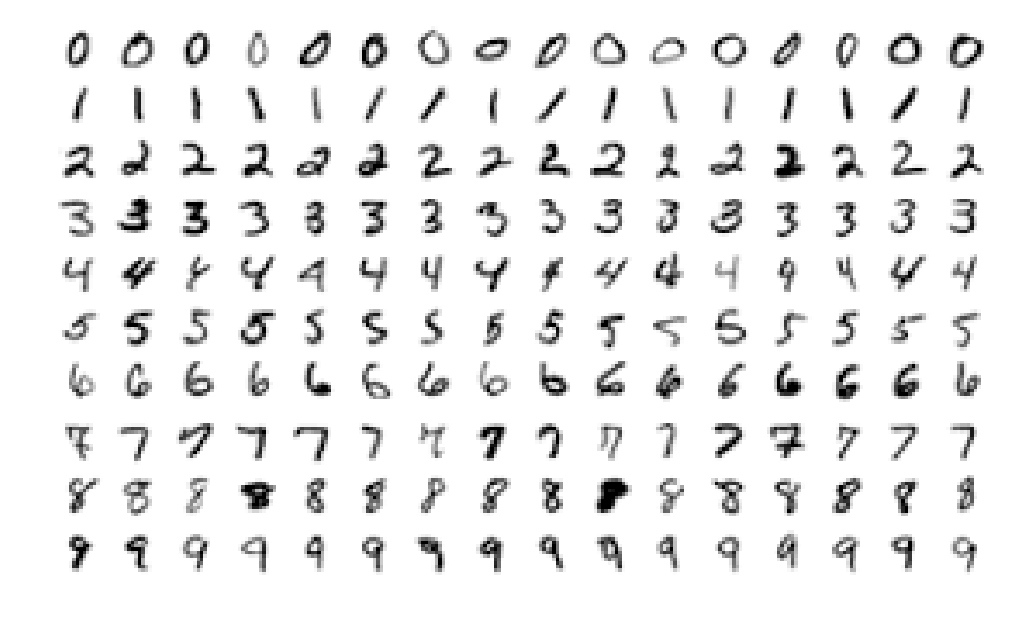

In [247]:
# vizualizace MNIST

mnist_nahled = mpimg.imread('mnist.png')
plt.figure(figsize=(13, 8), dpi=100)
plt.axis('off')
plt.imshow(mnist_nahled)

### Hlavní výpočetní kroky

1. Načtení dat 
2. Vytvoření iterovatelného datasetu
3. Vytvoření třídy modelu neuronové sítě 
4. Instance modelu 
5. Instance ztrátové třídy
6. Instance třídy oplimalizačního algoritmu 
7. Trénování modelu a ověření přesnosti modelu 

### Instalace PyTorch 

`pip install torch`

`pip install torchvision`

PyTorch zahrnuje balíček **torchvision**, který se používá pro distribuci datových sad a jejich přípravu a transformaci pro práci s modely neuronových sítí. Tent o balíček obsahuje dvě základní funkce `Dataset` a `DataLoader`, které pomáhají s přípravou a transformací dat při procesu učení a predikce. 

# Knihovny

In [248]:
# práce s daty
import numpy as np
np.random.seed(42)
import os
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch a Torchvision 
import torch
# třída Neural Network 
import torch.nn as nn 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets 


In [249]:
print(torch.__version__)
print(torchvision.__version__)

1.13.0
0.14.0


In [ ]:
""" 1: Načtení dat: MNIST """

# Linux 
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz 

In [ ]:
# from torchvision.datasets import MNIST
# transform = transforms.Compose([transforms.ToTensor()])
# train_data = MNIST(root = './MNIST', train=True, download=True, transform=transform)
# test_data = MNIST(root = './MNIST', train=False, download=True, transform=transform)

In [ ]:
# stažení dat 
train_dataset = dsets.MNIST(root='./data', train = True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

In [ ]:
train_dataset

In [ ]:
test_dataset

In [ ]:
# atributy data a targets 
print(train_dataset.data.size())
print(train_dataset.targets.size())

In [ ]:
print(test_dataset.data.size())
print(test_dataset.targets.size())

In [ ]:
type(train_dataset)

In [ ]:
# (train_dataset[0][0]).numpy()

In [ ]:
train_dataset_array = train_dataset[0][0].numpy()
plt.imshow(train_dataset_array[0,:,:], cmap='gray', interpolation='none')

In [ ]:
train_dataset.targets[0].numpy()

In [ ]:
""" 2: Vytvoření iterovatelného datasetu """

batch_size = 100 
n_iters = 3000

num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)


test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

In [ ]:
print('Počet epoch: {}'.format(num_epochs))


In [ ]:
""" 3:  Třída modelu neuronové sítě  """

class CNNModel(nn.Module):
    
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # inicializace modelu: příprava komponentů sítě 
        
        # konvolučni vrstva(velikost vstupu, velikost výstupu, velikost filteru, krok, okraje) 
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        # maxpool vrstva - převzorkování 
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # lineární vrstva - plně propojená 
        self.fc3 = nn.Linear(16*7*7, 64)
        
        self.fc4 = nn.Linear(64, 32)
        
        self.fc5 = nn.Linear(32, 10)
        # Softmax výstupní aktivační funkce 
        self.softmax = nn.Softmax(dim=1)
   
    
    def forward(self, x):
        # dopředný chod (dopředná propagace) 
        
        # POOL(ReLU(CONVOLUCE))
        x = self.pool1(F.relu(self.conv1(x)))
        # print('Layer 1:')
        # print(x.shape)
        
        x = self.pool2(F.relu(self.conv2(x)))
        # print('Layer 2:')
        # print(x.shape)
        
        # změna dimenyionality - přchod mezi konvolučními a lineárními vrstvami sítě 
        # flattening: 16*7*7 = 784
        x = x.view(x.size(0), -1)
        # print('Reshape:')
        # print(x.shape)
        
        # lineární jednotka aktivována ReLU 
        x = F.relu(self.fc3(x))
        # print('Layer 3:')
        # print(x.shape)

        x = F.relu(self.fc4(x))
        # print('Layer 4:')
        # print(x.shape)
        
        # výstupní Softmax 
        x = self.softmax(self.fc5(x))
        # print('Layer 5:')
        # print(x.shape)

        return x


In [ ]:
""" 4: Inicializace třídy konvoluční neuronové sítě  """

model = CNNModel()

In [ ]:
model

In [ ]:
# test 
# sim_img = torch.ones(1, 1, 28, 28)
# model(sim_img)

In [ ]:
# PARAMETRY 
# print(model.parameters())

# Conv 1:
print(list(model.parameters())[0].size())

# Conv 1 bias: 
print(list(model.parameters())[1].size())

# Conv 2: 
print(list(model.parameters())[2].size())

# Conv 2 bias:
print(list(model.parameters())[3].size())

# Fully connected lineární vrstva 
print(list(model.parameters())[4].size())

# Fully connected: bias
print(list(model.parameters())[5].size())

In [ ]:
""" 5: Inicializace ztrátové funkce  """

# Křížová entropie
criterion = nn.CrossEntropyLoss()

In [ ]:
""" 6: Inicializace třídy optimalizačního algoritmu """

# tlumení rychlosti učení 
learning_rate = 0.001
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
""" 7: Proces učení modelu """
# POZOR PROCES TRVA DELE!!! 

# iterativní proces přes definované epochy 
iter = 0
for epoch in range(num_epochs):
    # načtení dávky obrazových dat (images) a jejich reference (labels/targets) z iterátoru trénovacích dat 
    for i, (images, labels) in enumerate(train_loader):
        # načtení snímků a referencí do třídy Variables 
        # tensory třídy Variable umožňují automaické diferencování - zpětný chod 
        images = Variable(images) # X
        labels = Variable(labels) # y 

        # vyčištění gradientů z předchoyího kroku - inicializace 
        optimizer.zero_grad()
        # dopředný chod modelu - predikce výsledku 
        outputs = model(images)
        # výpočet ztráty 
        loss = criterion(outputs, labels)
        # zpětný chod - výpočet gradientů 
        loss.backward()
        # aktualizace parametrů sítě 
        optimizer.step()
        iter += 1

        # výpočet přesnosti modelu (1x za 100 iterací)    
        if iter % 100 == 0:
            correct = 0
            total = 0
            # iterace přes prvky testovacího data setu 
            for images, labels in test_loader:
                # převedení na proměnou Variable
                images = Variable(images)

                # dopředný chod sítě 
                outputs = model(images)
                # převedení pravděpodobností na diskrétní hodnoty tříd 
                _, predicted = torch.max(outputs.data, 1)
                # celkový počet referencí 
                total += labels.size(0)
                # počitadlo správných predikcí 
                correct += (predicted == labels).sum()
            # celková přesnost 
            accuracy = 100 * correct / total
            print('Iterace: {}. Ztráta: {}. Celková přesnost: {}'.format(iter, loss.item(), accuracy))


In [ ]:
print("Celková výsledná přesnost je: {} %".format(round(float(accuracy), 2)))

In [ ]:
# Úkol 1: Vzykreslete graf závislosti ztráty a přesnosti modelu na počtu iterací 

In [ ]:
# Úkol 2: Zvětšete komlexitu modelu a ověřte přesnot 

In [ ]:
# Úkol 3: Zmenšete komplexitu modelu a ověřte přesnost 